# **Customer Support Bot Router**

Nomes:

        Bruno Rodrigues

        Camila Polo

        Romão Martines

### **1. Objetivo e Contexto**

O objetivo desse projeto é construir uma aplicação que consiga encaminhar um cliente que entra em contato com o serviço de suporte de uma empresa para o atendimento especializado.


Chatbots têm sido comumente usados por empresas para realizar uma parte do atendimento ao cliente ou até mesmo o atendimento completo em diversos casos. Esses bots são uma forma de gerar tanto economia quanto eficiência para uma empresa. Imagine um grande varejista que possui lojas online, por exemplo. Normalmente esse varejista possuirá diferentes setores, cada um relacionado com uma fase da compra (entrega, troca, reembolso, por exemplo). Cada um desses setores contará com especialistas naquela área específica de atuação. Nada mais natural que os responsáveis pelo atendimento sejam também especialistas numa determinada área, pois conseguirão resolver os problemas que surgirem com mais eficiência. Dessa forma, é interessante que as solicitações que envolvem essas diferentes fases de uma compra sejam encaminhadas para o setor correto.

Uma solução eficiente para esse problema, é criar um atendimento automático que sirva de entrada para todas as solicitações e saiba fazer o encaminhamento da demanda ao setor correto, de forma que o cliente inicie o chat com um robô e possa ser encaminhado a um chat com um atendente especializado, se necessário.

### **2.Base de dados**

A base de dados que será utilizada para treinar o modelo está disponível no [Kaggle](https://www.kaggle.com/datasets/536db59649ec509a2808c8d2c85d560c64e1dce44778a22ab79ce3408813e8fb). A base está em inglês e dessa forma só poderá classificar textos nessa língua.

O dataset contém cerca de 20000 registros/sentenças e a classificação da intenção destas sentenças. As categorias de intenção contidas no dataset foram selecionadas de forma que as escolhidas são aquelas que estão presentes em diferentes tipos de negócios. 

O dataset também possui uma coluna nomeada de "flags" que indicam as características de linguagem do registro, como polidez, uso de palavrões, formalidade, etc.

Lista de categorias e intenções contidas no dataset:

* ACCOUNT
* CANCELLATION_FEE
* CONTACT
* DELIVERY
* FEEDBACK
* INVOICES
* NEWSLETTER
* ORDER
* PAYMENT
* REFUNDS
* SHIPPING

Dentro dessas categorias, temos as seguintes intenções:

cancel_order

complaint

contact_customer_service

contact_human_agent

create_account

change_order

change_shipping_address

check_cancellation_fee

check_invoices

check_payment_methods

check_refund_policy

delete_account

delivery_options

delivery_period

edit_account

get_invoice

get_refund

newsletter_subscription

payment_issue

place_order

recover_password

registration_problems

review

set_up_shipping_address

switch_account

track_order

track_refund

O chatbot, ao receber uma solicitação contendo alguma das intenções categorizadas no dataset de treinamento deverá ser capaz de rotear a solicitação para o setor especializado.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Projeto_NLP/chatbot_df.csv")

In [ ]:
df

,flags,utterance,category,intent
0,BILC,"I don't have an online account, what do I have...",ACCOUNT,create_account
1,BILQZ,can you tell me if i can regisger two accounts...,ACCOUNT,create_account
2,BPLC,"I have no online account, open one, please",ACCOUNT,create_account
3,BIPLD,"could you ask an agent how to open an account,...",ACCOUNT,create_account
4,BLQC,"i want an online account, create one",ACCOUNT,create_account
...,...,...,...,...
21529,BILQC,"i have no shipping address, what do i have to ...",SHIPPING,set_up_shipping_address
21530,BLQC,I have no shipping address and I want to set o...,SHIPPING,set_up_shipping_address
21531,BIQC,"i want to set up my shipping address, what do ...",SHIPPING,set_up_shipping_address
21532,BILC,"I don't have a shipping address, can you set o...",SHIPPING,set_up_shipping_address


### **3. Análise do conteúdo**

In [ ]:
from wordcloud import WordCloud

In [ ]:
all_words = ' '.join([text for text in df.utterance])

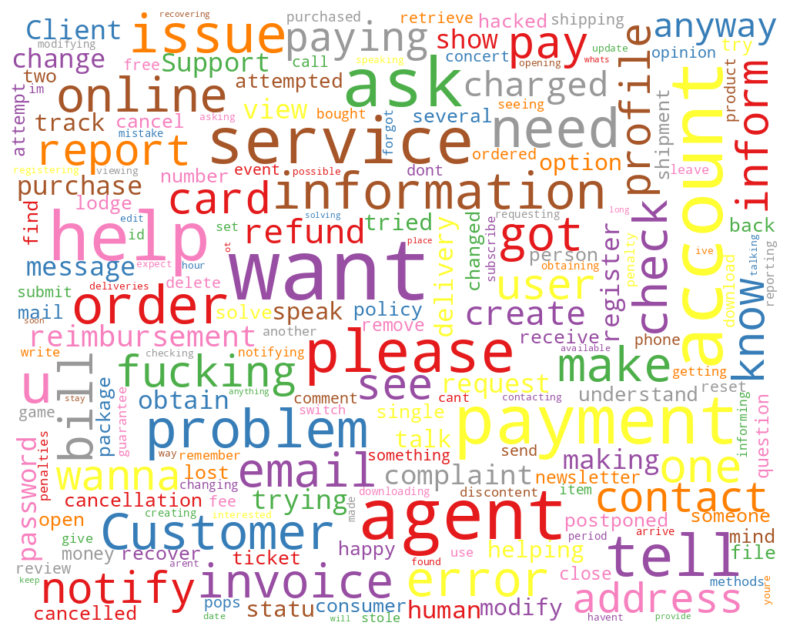

In [ ]:
nuvem_palavras = WordCloud(width= 1000, height= 800, max_font_size = 110, background_color="white", colormap='Set1', collocations= False).generate(all_words)
plt.figure(figsize=(12,8))
plt.imshow(nuvem_palavras, interpolation='bilinear')
plt.axis("off")
plt.show()

Conseguimos perceber pela nuvem de palavras que temos no nosso corpus palavras com contrações ( "u", "dont", "cant"), maiúsculas e minúsculas, gírias e palavrões, palavras com spelling errado ("statu"), stopwords ("one", "in"). No próximo item tentaremos modificar e remover as palavras para deixar o corpus o mais informativo possível.

### **4.Limpeza e pré-processamento**

In [ ]:
!pip install nltk
!pip install spacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!python -m spacy download en

2023-05-13 19:00:47.170531: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-13 19:00:48.883626: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 33.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


**4.1 Contrações**

Em inglês, contrações são muito comuns. Dessa forma, é interessante realizar a transformação dessas contrações antes de realizar a retirada de pontuação ou a tokenização das palavras, já que as contrações poderiam afetar ou impedir que essas tarefas sejam executadas corretamente.

In [ ]:
CONTRACTION_MAP = {
    "ain't": "is not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "gonna": "going to",
    "gotta": "got to",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "u": "you",
    "wanna": "want to",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have",
}

In [ ]:
import re

def expand_contractions(text, contraction_map=CONTRACTION_MAP, lower=False):
    text_expanded = str(text)  # copy
    if lower:
        text_expanded = text_expanded.lower()
    
    for contraction, normal in contraction_map.items():
        text_expanded = re.sub(contraction, normal, text_expanded)
    
    return text_expanded

In [ ]:
 df['no_contract_utterance'] = df.apply(lambda row : expand_contractions(row['utterance']), axis = 1)

**4.2 Pontuação**

A pontuação também não é um elemento informativo para o nosso problema e para praticamente todos os problemas que envolvem NLP. Dessa forma, faremos a remoção dessa pontuação.

In [ ]:
def remove_punctuation(text):
    regex = '[^\w\s]'
    
    return re.sub(regex, '', text)

In [ ]:
 df['no_punctuation'] = df.apply(lambda row : remove_punctuation(row['no_contract_utterance']), axis = 1)

**4.3 Lowercase**

Uma mesma palavra escrita com formatação de maiúsculas e minúsculas diferentes será entendida como sendo palavras diferentes. Dessa forma, iremos passar todos os caracteres das palavras do corpus para minúsculas.

In [ ]:
 df['lowercase'] = df['no_punctuation'].str.lower()

**4.4 Stopwords**

Stopwords são aquelas palavras que não adicionam informação a um determinado contexto e portanto não é interessante utilizá-las na modelagem de um problema de NLP. 

Preposições, pronomes e verbos auxiliares são exemplos de palavras que em geral não trazem informações relevantes em diversos contexto. Num contexto de separação de textos em tópicos,  palavras que expressam sentimentos negativos como a palavra "não" ou palavrões, também podem ser consideradas stopwords, dependendo dos tópicos nos quais queremos dividir os textos. 

Nesse caso específico, temos um tópico com a categoria "complaint" que seria uma reclamação. Nesse caso, entendemos que palavras como "not" e mesmo palavrões podem ser importantes para sinalizar esse tópico e dessa forma serão mantidas no corpus.

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

Na lista de stopwords do NLTK, já temos algumas contractions incluídas que não precisariam ter sido modificadas na etapa 4.1.

In [ ]:
stoplist = set(stopwords.words("english"))

In [ ]:
len(stoplist)

179

In [ ]:
#remove words that are in NLTK stopwords list
not_stopwords = {'not'} 
final_stopwords = set([word for word in stoplist if word not in not_stopwords])



In [ ]:
len(final_stopwords)

178

In [ ]:
def sentences_stopwords(lista):
  sentenca = ' '.join(lista)
  return sentenca

In [ ]:
df['no_stopwords'] = df['lowercase'].apply(word_tokenize)
df['no_stopwords'] = df['no_stopwords'].apply(lambda words: [word for word in words if word not in final_stopwords ])
df['no_stopwords'] = df.apply(lambda row : sentences_stopwords(row['no_stopwords']), axis = 1)

**4.5 Spelling**

In [ ]:
pip install -U symspellpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 6.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for editdistpy: filename=editdistpy-0.1.3-cp310-cp310-linux_x86_64.whl size=141760 sha256=f56882c6d9e70acf0807446891c93ebabab370f63dcf520e52936346c22841b3
  Stored in directory: /root/.cache/pip/wheels/88/6a/a6/a1283cc145323a1fb3d475bd158ee60b248ab1985230d266fc
Successfully built editdistpy


In [ ]:
import pkg_resources
from symspellpy import SymSpell, Verbosity

sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt"

)


bigram_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_bigramdictionary_en_243_342.txt"
)
# term_index is the column of the term and count_index is the
# column of the term frequency
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)


sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
sym_spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)



True

In [ ]:
def correct_spelling(input):

  input_term = input

  suggestions = sym_spell.lookup_compound(input_term, max_edit_distance=2)


  return suggestions[0].term

In [ ]:
from tqdm import tqdm
tqdm.pandas(desc='Progress')

In [ ]:
df["spelling_correction"]= df.progress_apply(lambda row : correct_spelling(row['no_stopwords']), axis = 1)

Progress: 100%|██████████| 21534/21534 [01:28<00:00, 244.29it/s]


In [ ]:
df.head(5)

,flags,utterance,category,intent,no_contract_utterance,no_punctuation,lowercase,no_stopwords,spelling_correction
0,BILC,"I don't have an online account, what do I have...",ACCOUNT,create_account,"I do not have an online accoyount, what do I h...",I do not have an online accoyount what do I ha...,i do not have an online accoyount what do i ha...,not online accoyount register,not online account register
1,BILQZ,can you tell me if i can regisger two accounts...,ACCOUNT,create_account,can yoyou tell me if i can regisger two accoyo...,can yoyou tell me if i can regisger two accoyo...,can yoyou tell me if i can regisger two accoyo...,yoyou tell regisger two accoyounts single emai...,a you tell register two accounts single email ...
2,BPLC,"I have no online account, open one, please",ACCOUNT,create_account,"I have no online accoyount, open one, please",I have no online accoyount open one please,i have no online accoyount open one please,online accoyount open one please,online account open one please
3,BIPLD,"could you ask an agent how to open an account,...",ACCOUNT,create_account,coyould yoyou ask an agent how to open an acco...,coyould yoyou ask an agent how to open an acco...,coyould yoyou ask an agent how to open an acco...,coyould yoyou ask agent open accoyount please,could a you ask agent open account please
4,BLQC,"i want an online account, create one",ACCOUNT,create_account,"i want an online accoyount, create one",i want an online accoyount create one,i want an online accoyount create one,want online accoyount create one,want online account create one


**4.6 Lemmatization**

Na lemmatization vamos buscar reduzir a palavra à sua raiz, retirando todas as inflexões e chegando ao lemma. Porém, diferentemente do stemming, essa redução sempre resultará em uma palavra que realmente existe na gramática. Outro ponto importante é que, nessa técnica, a classe gramatical da palavra será levada em consideração para fazer a redução. Dessa forma, escolhemos aplicar uma lemmatização no corpus.

In [ ]:
import spacy
load_model = spacy.load('en_core_web_sm', disable = ['parser','ner'])

In [ ]:
def apply_lemmatizer(lista):
  doc = load_model(lista)
  return " ".join([token.lemma_ for token in doc])
 

In [ ]:
df['lemma']= df.apply(lambda row : apply_lemmatizer(row['spelling_correction']), axis = 1)

In [ ]:
df.head(1)

,flags,utterance,category,intent,no_contract_utterance,no_punctuation,lowercase,no_stopwords,spelling_correction,lemma
0,BILC,"I don't have an online account, what do I have...",ACCOUNT,create_account,"I do not have an online accoyount, what do I h...",I do not have an online accoyount what do I ha...,i do not have an online accoyount what do i ha...,not online accoyount register,not online account register,not online account register


**Nuvem de palavras após pré-processamento do texto**

In [ ]:
all_words = ' '.join([text for text in df.lemma])

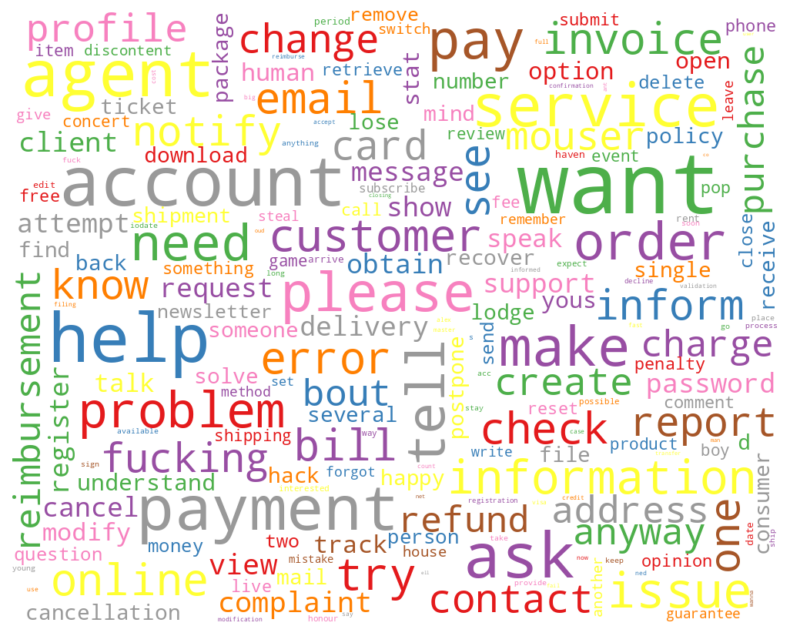

In [ ]:
nuvem_palavras = WordCloud(width= 1000, height= 800, max_font_size = 110, background_color="white", colormap='Set1', collocations= False).generate(all_words)
plt.figure(figsize=(12,8))
plt.imshow(nuvem_palavras, interpolation='bilinear')
plt.axis("off")
plt.show()